In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import traceback

DATA_PATH = '/workspaces/Tracking-Gazes-on-Museum-Pieces-Data-Plus/data'

def concat_df(DATA_PATH):
    df = pd.DataFrame()
    for folder in os.listdir(DATA_PATH):
        if not os.path.isdir(os.path.join(DATA_PATH, folder)):
            continue
        temp_path = os.path.join(DATA_PATH, folder, 'gaze.csv')
        temp_df = pd.read_csv(temp_path)
        temp_df['folder_id'] = folder
        df = pd.concat([df, temp_df])
    return df

"""
print('Participant count', gaze_df['section id'].nunique())
gaze_df = pd.merge(demographic_data, gaze_df, left_on='codice_eyetr_museo', right_on='folder_id', how='right')
gaze_df.replace({'m': 0, 'f': 1}, inplace=True)
print('Row count', gaze_df.shape[0])
print('Participant count', gaze_df['section id'].nunique())
print('Participant count', gaze_df['codice_eyetr_museo'].nunique())
display(gaze_df.head())
"""

demographic_data = pd.read_excel(os.path.join(DATA_PATH, 'demographic.xlsx'))
orig_data = concat_df(DATA_PATH)
modified_data = pd.read_csv(os.path.join(DATA_PATH, 'all_gaze.csv'), compression='gzip')
keep_columns = ['timestamp [ns]_for_grouping', 'participant_folder', 'ref_center_x', 'ref_center_y']
modified_data = modified_data[keep_columns]

### Creating the required computation columns
1. Distance
2. Velocity
3. Acceleration
4. Angular Velocity

Velocity and acceleration were computed as the
first and second derivative of position, respectively. Distance was
measured as the Euclidiandistance betweenthe positionofthe scan
path at a time point to the position of the scan path two time points
later. Angular velocity was calculated as the difference in the angle
of the scan path from one time point to the next. Angular velocity was subtracted from 360◦ so that lower values were associated
with fixations. 

In [11]:
def calculate_distance(df):
    """
    Distance was measured as the Euclidiandistance betweenthe positionofthe scan
    path at a time point to the position of the scan path two time points later
    """
    df['ref_center_x_shifted'] = df['ref_center_x'].shift(2)
    df['ref_center_y_shifted'] = df['ref_center_y'].shift(2)
    df['distance'] = np.linalg.norm(df.loc[:, ['ref_center_x','ref_center_y']].values - df.loc[:, ['ref_center_x_shifted','ref_center_y_shifted']], axis=1)
    df.drop(columns=['ref_center_x_shifted', 'ref_center_y_shifted'], inplace=True)
    return df

def calculate_velocity(df):
    """
    Velocity and acceleration were computed as the
    first and second derivative of position, respectively.
    """
    df['velx'] = df['ref_center_x'].diff()
    df['vely'] = df['ref_center_y'].diff()
    df['vel'] = np.sqrt(df['velx']**2 + df['vely']**2)

    df['accel'] = abs(df['vel'].diff())

    df['angle'] = np.arctan2(df['velx'], df['vely'])/np.pi
    df['rot'] = abs(df['angle'] - df['angle'].shift(-1))
    df.loc[df['rot'] > 180, 'rot'] = df['rot'] - 180
    df['rot'] = 360 - df['rot']
    df.drop(columns=['velx', 'vely', 'angle'], inplace=True)
    return df


modified_data = modified_data.groupby('participant_folder').apply(calculate_distance).reset_index(drop=True)
modified_data = modified_data.groupby('participant_folder').apply(calculate_velocity).reset_index(drop=True)
modified_data.head()

,timestamp [ns]_for_grouping,participant_folder,ref_center_x,ref_center_y,distance,vel,accel,rot
0,1638871076374815336,2021_01bmf,504,559,NaN,NaN,NaN,NaN
1,1638871076414879336,2021_01bmf,499,562,NaN,5.830952,NaN,359.859188
2,1638871076438757336,2021_01bmf,493,571,16.278821,10.816654,4.985702,359.415249
3,1638871076474801336,2021_01bmf,499,573,11.000000,6.324555,4.492099,359.475563
4,1638871076506757336,2021_01bmf,502,561,13.453624,12.369317,6.044762,359.077979


### Apply standarization
For each state space parameter, any values greater
than 3 standard deviations above the mean were set to 3 standard
deviations above the mean, and all values were then normalized
from 0 to 1.

In [12]:
def standardize_cols(df):
    cols_list = ['distance', 'vel', 'accel', 'rot']
    for col in cols_list:
        thresh = np.mean(df[col]) + 3*np.std(df[col])
        df.loc[df[col] > thresh, col] = thresh
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())  
    return df
        
modified_data = modified_data.groupby('participant_folder').apply(standardize_cols).reset_index(drop=True)
modified_data.head()

,timestamp [ns]_for_grouping,participant_folder,ref_center_x,ref_center_y,distance,vel,accel,rot
0,1638871076374815336,2021_01bmf,504,559,NaN,NaN,NaN,NaN
1,1638871076414879336,2021_01bmf,499,562,NaN,0.049485,NaN,0.928723
2,1638871076438757336,2021_01bmf,493,571,0.096321,0.091797,0.041100,0.704008
3,1638871076474801336,2021_01bmf,499,573,0.065087,0.053674,0.037031,0.734538
4,1638871076506757336,2021_01bmf,502,561,0.079605,0.104974,0.049831,0.533287


### Clustering the data

In [ ]:
def apply_clustering(df):
    try:

        sil = np.zeros(5)  # determines the number of clusters by comparing the ratio
        # of intercluster and intracluster distances, faster mod of silhouette

        for numclusts in range(2, 6):
            # can save a little bit of computation by only using 3/4 parameters (-distance) and 1/10 of data points
            T = KMeans(n_clusters=numclusts, n_init=5).fit(points[::10, 1:4])
            silh = InterVSIntraDist(points[::10, 1:4], T.labels_)
            sil[numclusts-1] = np.mean(silh)

        sil[sil > 0.9*np.max(sil)] = 1
        numclusters = np.where(sil == np.max(sil))[0]
        T = KMeans(n_clusters=numclusters[-1], n_init=5).fit(points)
        meanvalues = np.zeros((np.max(T.labels_)+1, points.shape[1]))
        stdvalues = np.zeros((np.max(T.labels_)+1, points.shape[1]))

        for TIND in range(1, np.max(T.labels_)+1):
            tc = np.where(T.labels_ == TIND)[0]
            meanvalues[TIND-1, :] = np.mean(points[tc, :], axis=0)
            stdvalues[TIND-1, :] = np.std(points[tc, :], axis=0)
    except exception as ee:
        print(traceback.print_exc(ee))


modified_data.groupby('participant_folder').apply(standardize_cols).reset_index(drop=True)

In [8]:
subset_participants = list(modified_data['participant_folder'].unique())[:9]
# fig, axes = plt.subplots(len(subset_participants), 2, figsize=(15,30))
num_clusters = 5
labels = []
for idx, person in enumerate(subset_participants):
    temp = modified_data[modified_data['participant_folder'] == person]
    temp.dropna(inplace=True)
    dataset = temp[['distance', 'vel', 'accel', 'rot']]
    inertias = []
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dataset)
    labels.append(kmeans.labels_)
    """
    Visualize elbow
    for k in range(1, num_clusters):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(dataset)
        inertias.append(kmeans.inertia_)
        labels.append(kmeans.labels_)


    axes[idx][0].plot(range(1, num_clusters), inertias, marker='o')
    axes[idx][0].set_xlabel("Number of clusters")
    axes[idx][0].set_ylabel("Inertia")
    axes[idx][0].set_title("Elbow Method")
    """
    
    """
    ### Vizualize data
    img = axes[idx][1].scatter(dataset['distance'], dataset['vel'], dataset['accel'], c=dataset['rot'], cmap=plt.hot())
    fig.colorbar(img)
    axes[idx][1].set_title(f"Visualizing person {person}")
    """

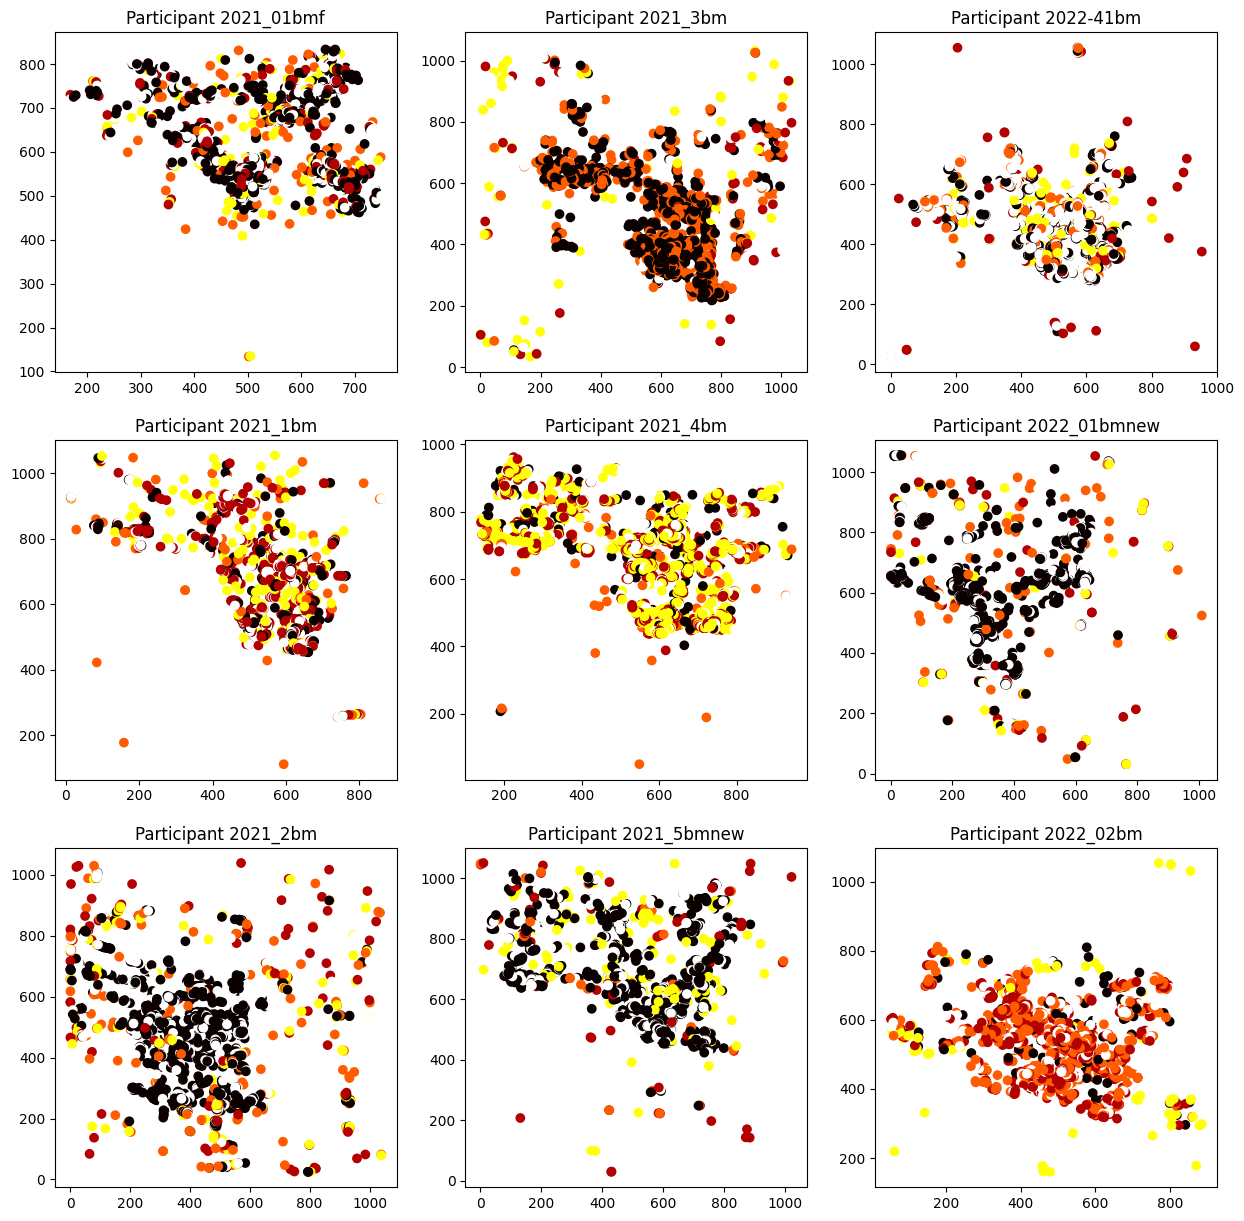

In [9]:
ncols = 3
nrows = 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15),)
current_col = 0
for current_col in range(ncols):
    for current_row in range(nrows):
        current_idx = nrows*current_col + current_row
        current_person = subset_participants[current_idx]
        
        temp = modified_data[modified_data['participant_folder'] == current_person]
        temp.dropna(inplace=True)
        axs[current_row, current_col].scatter(temp['ref_center_x'], temp['ref_center_y'], c=labels[current_idx], cmap=plt.hot())
        axs[current_row, current_col].set_title(f"Participant {current_person}")
plt.show()

### Process Overview/Assumptions/Questions
1. The output from the heatmap is considered smoothed/upsampled
2. Is a fourier transform required? What is the exact use of a fourier transform? (Something about converting time series to frequencies)
3. 

### Plotting original data vs Updated gaze data

ncols = 3
nrows = 4
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15),)
current_col = 0
persons_list = list(orig_data['folder_id'].unique())
for current_col in range(ncols):
    for current_row in range(nrows):
        current_person = persons_list[nrows*current_col + current_row]
        temp = orig_data[orig_data['folder_id'] == current_person]
        axs[current_row, current_col].plot(temp['gaze x [px]'], temp['gaze y [px]'])
        axs[current_row, current_col].set_title(f"Participant {current_person}")

plt.show()

ncols = 3
nrows = 4
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15),)
current_col = 0
for current_col in range(ncols):
    for current_row in range(nrows):
        current_person = persons_list[nrows*current_col + current_row]
        temp = modified_data[modified_data['participant_folder'] == current_person]
        axs[current_row, current_col].plot(temp['ref_center_x'], temp['ref_center_y'])
        axs[current_row, current_col].set_title(f"Participant {current_person}")

plt.show()